In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from scipy.stats import ttest_ind
from time import process_time
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from yellowbrick.cluster import KElbowVisualizer

#from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn import preprocessing
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.feature_selection import SelectFromModel

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score, roc_curve
from sklearn.metrics import make_scorer, confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier, XGBRegressor
#import lightgbm as lgb

from sklearn.ensemble import GradientBoostingClassifier as Gboost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#import warnings
#warnings.filterwarnings('always')


## Sections ##

1. Problem definition


2. Loading data


3. Understanding the data


4. Cleaning Data


5. Exploratory data analysis

    5.1. Hypothesises

    5.2. Distribution of Target
    

6. Data Preparation

    6.1. Feature Selection

    6.2. Balanced and split data
    

7. Algorithm Evaluation

    7.1. Support Vector Classification 

    7.2. Gaussian Naive Bayes (GaussianNB)

    7.3   KNeighborsClassifier
    

8. Testing all models  and evaluate performance to Unknown data (testing data) 

    8.1. SVC

    8.2 Gaussian Naive Bayes 

    8.3 KNeighborsClassifier
    
   
9. Normalization data and use ROC AUC metric for Decision Tree, Logistic Regression, RandomForestClassifier, XGBoost, AdaboostClassifier models


10. Summary







  # 1. Problem definition #

 One of the key tasks of the bank is to be able to determine to whom it can extend credit and to whom it cannot. Historically, it has been proven that a large part of the bank's profit is formed precisely from the service of providing credits. Every single bank follows the Basel Committee on Banking Supervision regulations. In case of delay or non-return of credit, it is obliged to freeze part of its assets, thereby depriving itself of the opportunity to invest them and receive a profit.
 In my case data is collected from the FinTech company and converted to numeric values for better training and classifying the people who are able or not able to pay their credits.
 Banks as a conservative institution adhere to models that are interpretable, I will use a large number of models that are black boxes, but can be used as auxiliary for the bank to make the right decision, on such an important issue as credit scoring.

# 2. Loading data #

In [3]:
df = pd.read_csv('data_train.csv')
df.head()

,label,Age,Language,Sex,Marital,Has_Credit,Field,Month_of_birth,Day_of_birth,Region,Number_of_credits,Linked_cards,INPS_mln_sum,INPS_yes_no,Score_level,Score_class,Score_point,Changed_phone_number
0,0,34,1,2,6,2,13,12,1,12,1,0,0.0,0,0,0,-,1
1,0,38,1,1,5,1,10,7,1,13,1,2,0.0,0,0,0,-,1
2,0,35,1,2,4,2,9,8,1,13,4,1,1.0,1,0,0,-,1
3,0,27,1,1,5,2,13,7,1,12,1,2,1.0,0,0,0,-,1
4,0,32,1,2,4,2,10,7,1,13,3,1,2.0,1,0,0,-,1


# 3. Understanding the data #

In [4]:
df.shape

(8707, 18)

In [5]:
df.isnull().sum() # check if the data has any missing values

label                   0
Age                     0
Language                0
Sex                     0
Marital                 0
Has_Credit              0
Field                   0
Month_of_birth          0
Day_of_birth            0
Region                  0
Number_of_credits       0
Linked_cards            0
INPS_mln_sum            0
INPS_yes_no             0
Score_level             0
Score_class             0
Score_point             0
Changed_phone_number    0
dtype: int64

In [6]:
df.describe()

,label,Age,Language,Sex,Marital,Has_Credit,Field,Month_of_birth,Day_of_birth,Region,Number_of_credits,Linked_cards,INPS_mln_sum,INPS_yes_no,Score_level,Score_class,Changed_phone_number
count,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000
mean,0.923050,37.690479,1.147468,1.622488,4.540829,1.032043,10.485012,6.360859,1.462157,11.207190,1.119789,1.100838,2.132932,0.957505,0.547491,1.082807,0.112094
std,0.266527,10.750031,0.354592,0.484792,1.053161,0.176125,5.597442,3.405988,0.498594,3.020191,0.366915,0.315294,2.225331,0.201726,1.190702,2.447644,0.344394
min,0.000000,19.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,29.000000,1.000000,1.000000,4.000000,1.000000,6.000000,3.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,36.000000,1.000000,2.000000,4.000000,1.000000,13.000000,6.000000,1.000000,12.000000,1.000000,1.000000,1.700000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,44.000000,1.000000,2.000000,5.000000,1.000000,14.000000,9.000000,2.000000,13.000000,1.000000,1.000000,2.800000,1.000000,0.000000,0.000000,0.000000
max,1.000000,79.000000,2.000000,2.000000,7.000000,2.000000,22.000000,12.000000,2.000000,14.000000,5.000000,4.000000,86.300000,1.000000,4.000000,11.000000,3.000000


In [7]:
df.columns

Index(['label', 'Age', 'Language', 'Sex', 'Marital', 'Has_Credit', 'Field',
       'Month_of_birth', 'Day_of_birth', 'Region', 'Number_of_credits',
       'Linked_cards', 'INPS_mln_sum', 'INPS_yes_no', 'Score_level',
       'Score_class', 'Score_point', 'Changed_phone_number'],
      dtype='object')

In [8]:
# small research what is INPS ( Istituto Nazionale Previdenza Sociale) National Social Security Institute of Italy

# 4. Cleaning data #

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8707 entries, 0 to 8706
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   label                 8707 non-null   int64  
 1   Age                   8707 non-null   int64  
 2   Language              8707 non-null   int64  
 3   Sex                   8707 non-null   int64  
 4   Marital               8707 non-null   int64  
 5   Has_Credit            8707 non-null   int64  
 6   Field                 8707 non-null   int64  
 7   Month_of_birth        8707 non-null   int64  
 8   Day_of_birth          8707 non-null   int64  
 9   Region                8707 non-null   int64  
 10  Number_of_credits     8707 non-null   int64  
 11  Linked_cards          8707 non-null   int64  
 12  INPS_mln_sum          8707 non-null   float64
 13  INPS_yes_no           8707 non-null   int64  
 14  Score_level           8707 non-null   int64  
 15  Score_class          

In [9]:
df['Score_point'] # this column  has some object

0         -
1         -
2         -
3         -
4         -
       ... 
8702      0
8703      0
8704      0
8705    237
8706    263
Name: Score_point, Length: 8707, dtype: object

In [10]:
df = df.replace({'-':0}) # replacing the object to 0

In [11]:
df['Score_point']

0         0
1         0
2         0
3         0
4         0
       ... 
8702      0
8703      0
8704      0
8705    237
8706    263
Name: Score_point, Length: 8707, dtype: object

In [12]:
# converting all columns to integer
columns = df.columns
for c in list(columns):
    df[c] = df[c].astype('int64')

In [13]:
df.info() # now we have only integer data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8707 entries, 0 to 8706
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   label                 8707 non-null   int64
 1   Age                   8707 non-null   int64
 2   Language              8707 non-null   int64
 3   Sex                   8707 non-null   int64
 4   Marital               8707 non-null   int64
 5   Has_Credit            8707 non-null   int64
 6   Field                 8707 non-null   int64
 7   Month_of_birth        8707 non-null   int64
 8   Day_of_birth          8707 non-null   int64
 9   Region                8707 non-null   int64
 10  Number_of_credits     8707 non-null   int64
 11  Linked_cards          8707 non-null   int64
 12  INPS_mln_sum          8707 non-null   int64
 13  INPS_yes_no           8707 non-null   int64
 14  Score_level           8707 non-null   int64
 15  Score_class           8707 non-null   int64
 16  Score_

In [14]:
df.nunique()

label                     2
Age                      59
Language                  2
Sex                       2
Marital                   7
Has_Credit                2
Field                    23
Month_of_birth           12
Day_of_birth              2
Region                   15
Number_of_credits         5
Linked_cards              5
INPS_mln_sum             21
INPS_yes_no               2
Score_level               5
Score_class              11
Score_point             192
Changed_phone_number      4
dtype: int64

In [15]:
df.Day_of_birth.unique() # maybe day of birth contains one or two digits

array([1, 2])

# 5. Exploratory data analysis #

## 5.1. Hypothesises ##
1. (Age) of people who are able to pay their credits is greater then who are not ablе.
2. (Region) People who live in better/ expensive areas (Region) probably will get credit more easily -correlation with (label)
3. (Field) probably the field in which you work matters whether you will get credit more easily (for example: a doctor or a taxi driver) - correlation with(label)
4. (INPS_yes_no) if you have Social Security is easy to get credit - correlation with(label)
5. (Score_class, Score_level, Score_points) correlate each other.

## 5.2. Distribution of Target ##

1    8037
0     670
Name: label, dtype: int64


<AxesSubplot:>

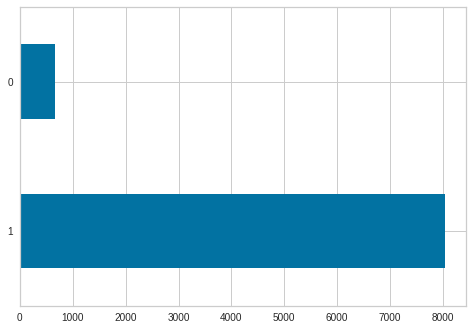

In [16]:
print(df['label'].value_counts())
df['label'].value_counts().plot.barh()
# distribution of target variable 'label'
# The target class is an unbalanced 

In [17]:
df.label.value_counts()/len(df) * 100
# zeroes are about 8% and ones are about 92%

1    92.305042
0     7.694958
Name: label, dtype: float64

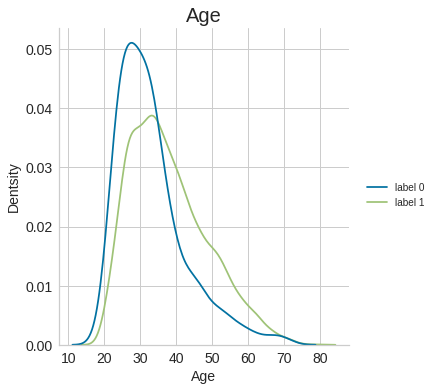

In [18]:
sns.displot(
            {
                "label 0":df[df.label == 0].Age,
                "label 1":df[df.label == 1].Age
            },
            kind = 'kde',
            common_norm=False
)
plt.title('Age', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [19]:
df.groupby('label')['Age'].median()

label
0    31.0
1    36.0
Name: Age, dtype: float64

In [20]:
df.groupby('label')['Age'].mean()

label
0    33.094030
1    38.073659
Name: Age, dtype: float64

I cannot reject hypothesis 1.

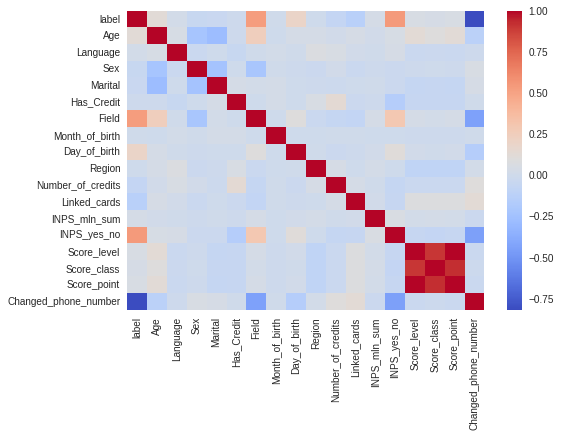

In [21]:
c = sns.heatmap(df.corr(),annot=False, fmt = ".2f", cmap = "coolwarm")

the same situation with another hypothesises

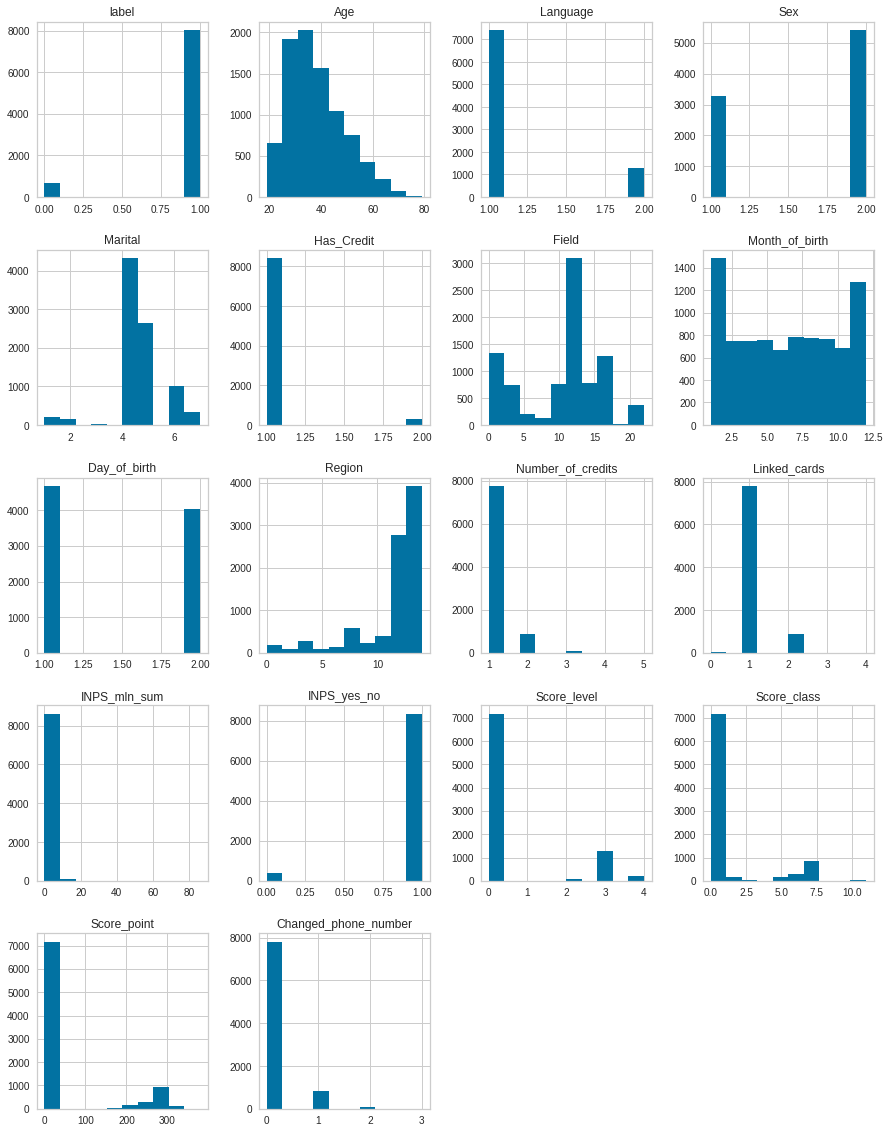

In [22]:
df.hist(figsize = (15,20));

search for outliers in data using elbow method, kmeans and DBScan

In [23]:
df.describe()

,label,Age,Language,Sex,Marital,Has_Credit,Field,Month_of_birth,Day_of_birth,Region,Number_of_credits,Linked_cards,INPS_mln_sum,INPS_yes_no,Score_level,Score_class,Score_point,Changed_phone_number
count,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000
mean,0.923050,37.690479,1.147468,1.622488,4.540829,1.032043,10.485012,6.360859,1.462157,11.207190,1.119789,1.100838,1.691168,0.957505,0.547491,1.082807,48.031469,0.112094
std,0.266527,10.750031,0.354592,0.484792,1.053161,0.176125,5.597442,3.405988,0.498594,3.020191,0.366915,0.315294,2.243876,0.201726,1.190702,2.447644,104.456343,0.344394
min,0.000000,19.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,29.000000,1.000000,1.000000,4.000000,1.000000,6.000000,3.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,36.000000,1.000000,2.000000,4.000000,1.000000,13.000000,6.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,44.000000,1.000000,2.000000,5.000000,1.000000,14.000000,9.000000,2.000000,13.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,79.000000,2.000000,2.000000,7.000000,2.000000,22.000000,12.000000,2.000000,14.000000,5.000000,4.000000,86.000000,1.000000,4.000000,11.000000,379.000000,3.000000


In [24]:
 X = df.drop('label', axis = 1)

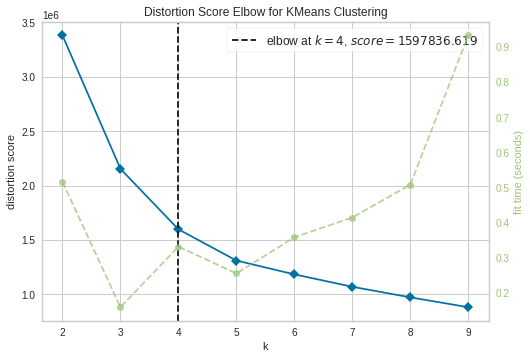

In [25]:
model = KMeans(random_state = 1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X)
visualizer.show()
plt.show()

we can find  reasonable value for epsilon

In [26]:
scala = StandardScaler()
df_scaled = scala.fit_transform(X) 

In [27]:
outlier_percent = []

for eps in np.linspace(0.001, 5, 100):
    
    dbscan = DBSCAN(eps=eps, min_samples = 36) # a good 'min_samples' number is two times the number of features
    dbscan.fit(df_scaled)
    perc_outliers = 100*np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    outlier_percent.append(perc_outliers)

Text(0, 0.5, 'Percentage of Points Classified as Outliers')

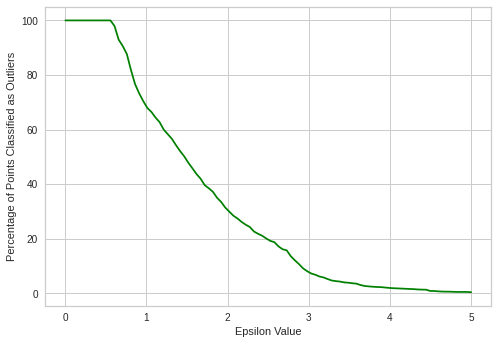

In [30]:
sns.lineplot(x=np.linspace(0.001, 5, 100), y=outlier_percent, color='green')
plt.xlabel('Epsilon Value')
plt.ylabel('Percentage of Points Classified as Outliers')

In [28]:
dend = linkage(df_scaled, method = "ward")
dend

array([[3.20000000e+01, 5.00000000e+01, 0.00000000e+00, 2.00000000e+00],
       [7.35000000e+02, 8.74000000e+02, 0.00000000e+00, 2.00000000e+00],
       [4.10000000e+01, 8.00000000e+01, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.73970000e+04, 1.74090000e+04, 1.33364311e+02, 1.10400000e+03],
       [1.74080000e+04, 1.74100000e+04, 1.51372784e+02, 7.28300000e+03],
       [1.74000000e+04, 1.74110000e+04, 2.15443262e+02, 8.70700000e+03]])

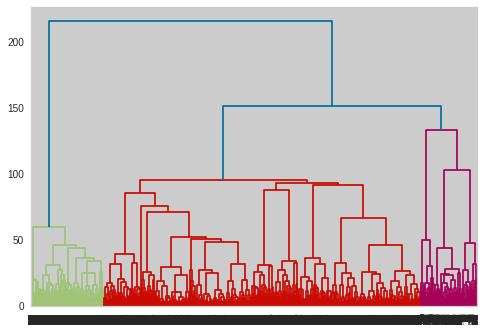

In [29]:
dendrogram(dend);

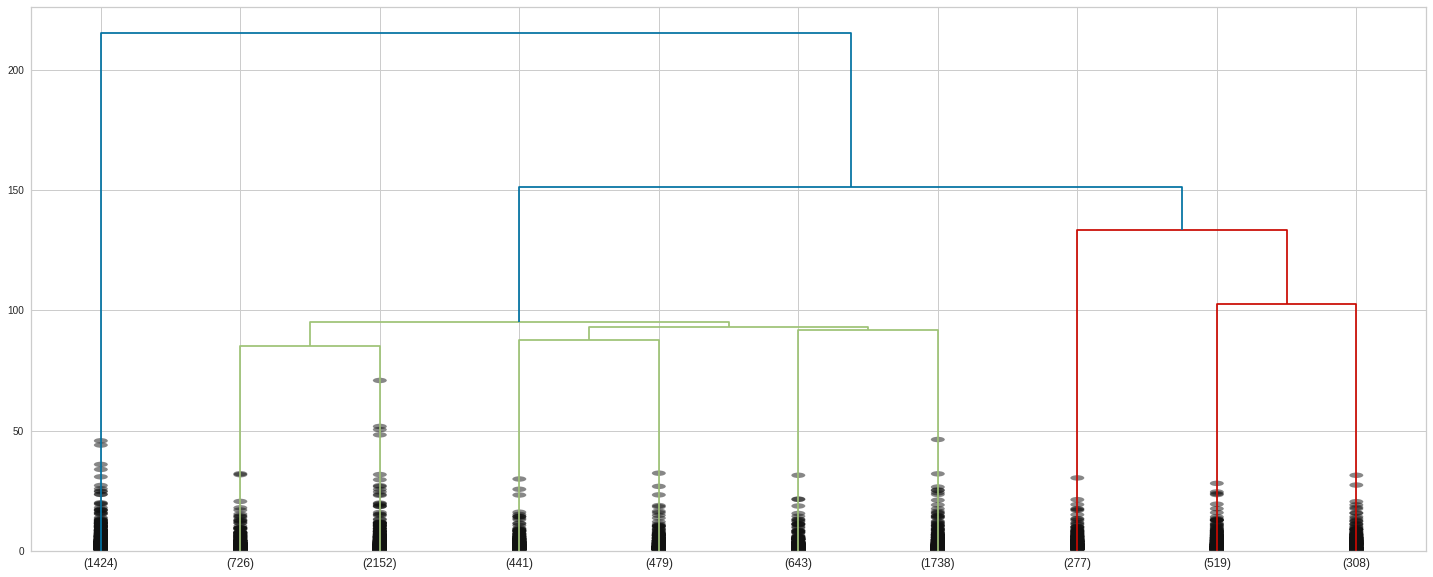

In [30]:
plt.figure(figsize = (25,10))
dendr = dendrogram(dend, truncate_mode="lastp", p = 10, show_leaf_counts = True, show_contracted = True)

In [34]:
#df_for_clust = preprocessing.normalize(X)
#df_for_clust

In [32]:
clusters = DBSCAN(eps = 4, min_samples = 36).fit_predict(df_scaled)

In [33]:
list(clusters).count(-1) 

165

165 outliers

<AxesSubplot:>

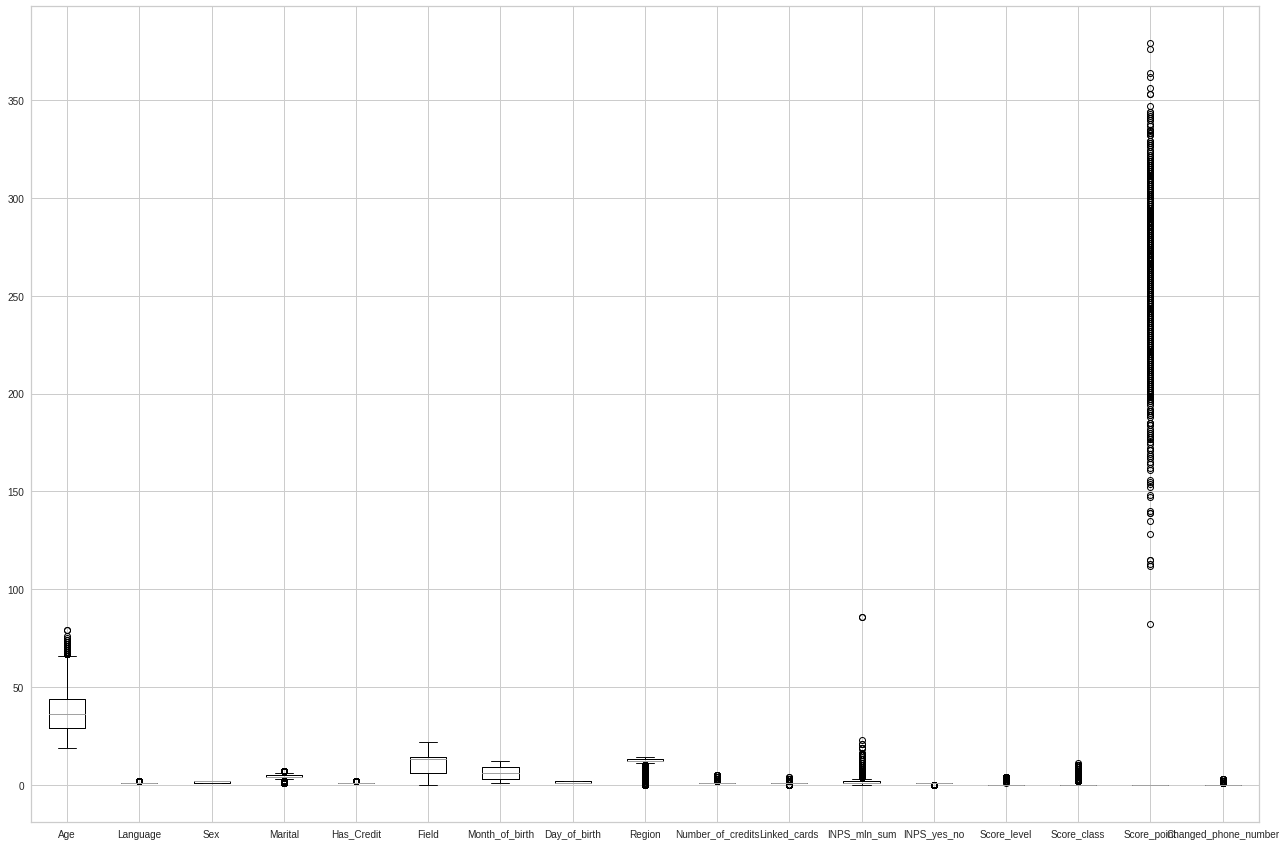

In [37]:
X.boxplot(figsize = (22,15))

In [34]:
df.describe()

,label,Age,Language,Sex,Marital,Has_Credit,Field,Month_of_birth,Day_of_birth,Region,Number_of_credits,Linked_cards,INPS_mln_sum,INPS_yes_no,Score_level,Score_class,Score_point,Changed_phone_number
count,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000
mean,0.923050,37.690479,1.147468,1.622488,4.540829,1.032043,10.485012,6.360859,1.462157,11.207190,1.119789,1.100838,1.691168,0.957505,0.547491,1.082807,48.031469,0.112094
std,0.266527,10.750031,0.354592,0.484792,1.053161,0.176125,5.597442,3.405988,0.498594,3.020191,0.366915,0.315294,2.243876,0.201726,1.190702,2.447644,104.456343,0.344394
min,0.000000,19.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,29.000000,1.000000,1.000000,4.000000,1.000000,6.000000,3.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,36.000000,1.000000,2.000000,4.000000,1.000000,13.000000,6.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,44.000000,1.000000,2.000000,5.000000,1.000000,14.000000,9.000000,2.000000,13.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,79.000000,2.000000,2.000000,7.000000,2.000000,22.000000,12.000000,2.000000,14.000000,5.000000,4.000000,86.000000,1.000000,4.000000,11.000000,379.000000,3.000000


In [38]:
df = df.drop(columns = ['Score_point']) # max 379, std 104, mean 48 corr with Score_level and Score_class

In [39]:
df.isnull().sum()

label                   0
Age                     0
Language                0
Sex                     0
Marital                 0
Has_Credit              0
Field                   0
Month_of_birth          0
Day_of_birth            0
Region                  0
Number_of_credits       0
Linked_cards            0
INPS_mln_sum            0
INPS_yes_no             0
Score_level             0
Score_class             0
Changed_phone_number    0
dtype: int64

In [40]:
for x in ['INPS_mln_sum']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

In [41]:
df.isnull().sum()

label                     0
Age                       0
Language                  0
Sex                       0
Marital                   0
Has_Credit                0
Field                     0
Month_of_birth            0
Day_of_birth              0
Region                    0
Number_of_credits         0
Linked_cards              0
INPS_mln_sum            950
INPS_yes_no               0
Score_level               0
Score_class               0
Changed_phone_number      0
dtype: int64

In [42]:
missing_col = ['INPS_mln_sum']
# Using median to impute the missing values
for i in missing_col:
     df.loc[df.loc[:,i].isnull(),i]=df.loc[:,i].median()

In [43]:
df.isnull().sum()

label                   0
Age                     0
Language                0
Sex                     0
Marital                 0
Has_Credit              0
Field                   0
Month_of_birth          0
Day_of_birth            0
Region                  0
Number_of_credits       0
Linked_cards            0
INPS_mln_sum            0
INPS_yes_no             0
Score_level             0
Score_class             0
Changed_phone_number    0
dtype: int64

In [44]:
df.describe()

,label,Age,Language,Sex,Marital,Has_Credit,Field,Month_of_birth,Day_of_birth,Region,Number_of_credits,Linked_cards,INPS_mln_sum,INPS_yes_no,Score_level,Score_class,Changed_phone_number
count,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000,8707.000000
mean,0.923050,37.690479,1.147468,1.622488,4.540829,1.032043,10.485012,6.360859,1.462157,11.207190,1.119789,1.100838,1.173653,0.957505,0.547491,1.082807,0.112094
std,0.266527,10.750031,0.354592,0.484792,1.053161,0.176125,5.597442,3.405988,0.498594,3.020191,0.366915,0.315294,0.937970,0.201726,1.190702,2.447644,0.344394
min,0.000000,19.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,29.000000,1.000000,1.000000,4.000000,1.000000,6.000000,3.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,36.000000,1.000000,2.000000,4.000000,1.000000,13.000000,6.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,44.000000,1.000000,2.000000,5.000000,1.000000,14.000000,9.000000,2.000000,13.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,79.000000,2.000000,2.000000,7.000000,2.000000,22.000000,12.000000,2.000000,14.000000,5.000000,4.000000,3.000000,1.000000,4.000000,11.000000,3.000000


In [45]:
df.shape

(8707, 17)

# 6. Data Preparation #

## 6.1. Feature Selection ##

In [46]:
cor = df.corr()

In [47]:
all_features = list(cor.columns)
features_to_del = []
for i in cor.columns:
    if i == 'label':
        continue
    for j in cor.index:
        if all_features.index(j) >= all_features.index(i) or j == 'label':
            continue
        else:
            if abs(cor.loc[i,j]) > 0.8:
                if abs(cor.loc['label', i]) > abs(cor.loc['label', j]):
                    features_to_del.append(j)
                else:
                    features_to_del.append(i)

In [48]:
features_to_del = set(features_to_del)
features_to_del

{'Score_class'}

In [49]:
for i in features_to_del:
    del df[i]
df.shape

(8707, 16)

## 6.2. Balanced and split data ##

in 5.2 we see that the data was unbalanced so we gonna balanced with RandomOverSampler

In [50]:
X = df.drop('label', axis = 1)
y = df['label']

#smote = SMOTE()
#X_smote, y_smote = smote.fit_resample(X,y)
#print(Counter(y_smote))

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
print(Counter(y_ros))

Counter({0: 8037, 1: 8037})


Now we are ready to split data

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size = 0.3, shuffle = True, random_state = 22, stratify = None)

In [52]:
print(X_train.shape, X_test.shape)

(11251, 15) (4823, 15)


In [53]:
print(y_train.shape, y_test.shape)

(11251,) (4823,)


let's check how similar are X_test and X_ros

In [54]:
test_mean = np.mean(X_test, axis = 0)
pred_mean = np.mean(X_ros, axis = 0)
print(len(test_mean), len(pred_mean))

15 15


In [55]:
ttest_ind(test_mean, pred_mean)

Ttest_indResult(statistic=-0.006455502634564179, pvalue=0.9948950652689357)

We have done our Data Preparation job

# 7. Algorithm Evaluation #

I am planning to start with Support Vector Machine model 

## 7.1. Support Vector Classification ##

In [56]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [57]:
svc_score = svc.score(X_test, y_test)
svc_score

0.9859008915612689

Let's try to improve result

In [58]:
svc_params = {
    "kernel" : ["poly", "rbf"]
}

In [59]:
grid_search_svc = GridSearchCV(SVC(), param_grid=svc_params)

In [60]:
grid_search_svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), param_grid={'kernel': ['poly', 'rbf']})

In [61]:
GridSearchCV(estimator=SVC(), param_grid={'kernel': ['poly', 'rbf']})

GridSearchCV(estimator=SVC(), param_grid={'kernel': ['poly', 'rbf']})

In [62]:
grid_search_svc_score = grid_search_svc.score(X_test, y_test)
grid_search_svc_score

0.9859008915612689

In [63]:
grid_search_svc.best_estimator_

SVC()

the same result now we try to improve playing with regularization paramether C

In [64]:
svc_params_v2 = {
    "C" : [0.1, 1, 10, 100]
}


In [65]:
grid_search_svc_v2 = GridSearchCV(SVC(), param_grid=svc_params_v2)

In [66]:
grid_search_svc_v2.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), param_grid={'C': [0.1, 1, 10, 100]})

In [67]:
GridSearchCV(estimator=SVC(), param_grid={'C': [0.1, 1, 10, 100]})

GridSearchCV(estimator=SVC(), param_grid={'C': [0.1, 1, 10, 100]})

In [68]:
grid_search_svc_v2_score = grid_search_svc_v2.score(X_test, y_test)
grid_search_svc_v2_score

0.9960605432303545

Good improvment

In [69]:
grid_search_svc_v2.best_estimator_

SVC(C=100)

In [70]:
grid_search_svc_v2.cv_results_

{'mean_fit_time': array([2.40402942, 1.6635283 , 0.90837564, 0.59491773]),
 'std_fit_time': array([0.02989412, 0.02658203, 0.01077035, 0.01974147]),
 'mean_score_time': array([0.59116015, 0.34781408, 0.15562425, 0.07915182]),
 'std_score_time': array([0.00262117, 0.00509439, 0.00131965, 0.00514718]),
 'param_C': masked_array(data=[0.1, 1, 10, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}],
 'split0_test_score': array([0.93736117, 0.98356286, 0.99644602, 0.99644602]),
 'split1_test_score': array([0.94622222, 0.984     , 0.99644444, 0.99644444]),
 'split2_test_score': array([0.948     , 0.98444444, 0.99777778, 0.99777778]),
 'split3_test_score': array([0.94355556, 0.98311111, 0.996     , 0.99733333]),
 'split4_test_score': array([0.94266667, 0.98      , 0.99644444, 0.99733333]),
 'mean_test_score': array([0.94356112, 0.98302368, 0.99662254, 0.99706698]),
 'std_test_score':

In [71]:
print(classification_report(y_train, grid_search_svc_v2.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5595
           1       1.00      1.00      1.00      5656

    accuracy                           1.00     11251
   macro avg       1.00      1.00      1.00     11251
weighted avg       1.00      1.00      1.00     11251



## 7.2. Gaussian Naive Bayes (GaussianNB) ##

In [72]:
Bayes = GaussianNB()
Bayes.fit(X_train, y_train)

GaussianNB()

In [73]:
Bayes_score = Bayes.score(X_test, y_test)
Bayes_score

0.9925357661206717

## 7.3 KNeighborsClassifier ##

In [74]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [75]:
knn_score = knn.score(X_test, y_test)
knn_score

0.9759485797221646

In [76]:
neighbours = {
    "n_neighbors" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 19]
}

In [77]:
knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=neighbours)
knn_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 19]})

In [78]:
GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [79]:
knn_grid_search.score(X_test, y_test)

0.9921210864607091

In [80]:
knn_grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [81]:
print(classification_report(y_train, knn_grid_search.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5595
           1       1.00      1.00      1.00      5656

    accuracy                           1.00     11251
   macro avg       1.00      1.00      1.00     11251
weighted avg       1.00      1.00      1.00     11251



Good improvment 

# 8. Testing 3 models  and evaluate performance to Unknown data (testing data) #

In [82]:
df1 = pd.read_csv('data_test.csv')
df1

,label,Age,Language,Sex,Marital,Has_Credit,Field,Month_of_birth,Day_of_birth,Region,Number_of_credits,Linked_cards,INPS_mln_sum,INPS_yes_no,Score_level,Score_class,Score_point,Changed_phone_number
0,0,40,1,2,4,1,0,3,1,12,2,1,2.4,1,0,0,-,1
1,0,36,2,2,4,1,0,5,1,13,1,2,0.0,1,0,0,-,1
2,0,31,1,2,4,1,0,7,1,13,1,1,0.3,0,0,0,-,2
3,0,29,1,2,4,1,0,1,1,13,1,1,0.9,1,0,0,-,1
4,0,38,1,2,4,1,0,10,1,13,1,2,4.3,0,4,2,318,1
5,0,33,1,2,4,1,0,9,1,13,1,2,0.8,0,3,6,263,1
6,0,34,1,1,5,1,0,4,1,12,1,2,0.1,1,0,0,-,1
7,0,28,1,2,4,1,0,8,1,13,1,1,1.6,1,0,0,-,1
8,0,33,1,1,5,1,0,6,1,13,1,2,3.7,0,2,8,108,1
9,0,35,1,1,5,1,0,10,1,13,1,1,0.8,0,0,0,-,1


In [ ]:
#df1 = df1.replace({'-':0}) # replacing the object to 0

In [83]:
df1 = df1.drop(columns = ['Score_point','Score_class'])

In [84]:
df1 

,label,Age,Language,Sex,Marital,Has_Credit,Field,Month_of_birth,Day_of_birth,Region,Number_of_credits,Linked_cards,INPS_mln_sum,INPS_yes_no,Score_level,Changed_phone_number
0,0,40,1,2,4,1,0,3,1,12,2,1,2.4,1,0,1
1,0,36,2,2,4,1,0,5,1,13,1,2,0.0,1,0,1
2,0,31,1,2,4,1,0,7,1,13,1,1,0.3,0,0,2
3,0,29,1,2,4,1,0,1,1,13,1,1,0.9,1,0,1
4,0,38,1,2,4,1,0,10,1,13,1,2,4.3,0,4,1
5,0,33,1,2,4,1,0,9,1,13,1,2,0.8,0,3,1
6,0,34,1,1,5,1,0,4,1,12,1,2,0.1,1,0,1
7,0,28,1,2,4,1,0,8,1,13,1,1,1.6,1,0,1
8,0,33,1,1,5,1,0,6,1,13,1,2,3.7,0,2,1
9,0,35,1,1,5,1,0,10,1,13,1,1,0.8,0,0,1


In [85]:
X_test1 = df1.drop('label', axis = 1, inplace =False)
y_test1 = df1['label']

In [86]:
X_test1

,Age,Language,Sex,Marital,Has_Credit,Field,Month_of_birth,Day_of_birth,Region,Number_of_credits,Linked_cards,INPS_mln_sum,INPS_yes_no,Score_level,Changed_phone_number
0,40,1,2,4,1,0,3,1,12,2,1,2.4,1,0,1
1,36,2,2,4,1,0,5,1,13,1,2,0.0,1,0,1
2,31,1,2,4,1,0,7,1,13,1,1,0.3,0,0,2
3,29,1,2,4,1,0,1,1,13,1,1,0.9,1,0,1
4,38,1,2,4,1,0,10,1,13,1,2,4.3,0,4,1
5,33,1,2,4,1,0,9,1,13,1,2,0.8,0,3,1
6,34,1,1,5,1,0,4,1,12,1,2,0.1,1,0,1
7,28,1,2,4,1,0,8,1,13,1,1,1.6,1,0,1
8,33,1,1,5,1,0,6,1,13,1,2,3.7,0,2,1
9,35,1,1,5,1,0,10,1,13,1,1,0.8,0,0,1


## 8.1. SVC ##

In [87]:
svc_new = svc.predict(X_test1)
print(accuracy_score(y_test1, svc_new).round(3))
print(confusion_matrix(y_test1, svc_new))
print(classification_report(y_test1,svc_new, zero_division=0))

1.0
[[26  0]
 [ 0 22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        22

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



## 8.2 Gaussian Naive Bayes ##

In [88]:
Bayes_new = Bayes.predict(X_test1)
print(accuracy_score(y_test1, Bayes_new).round(3))
print(confusion_matrix(y_test1, Bayes_new))
print(classification_report(y_test1, Bayes_new, zero_division=0))

1.0
[[26  0]
 [ 0 22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        22

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



WOW

## 8.3 KNeighborsClassifier ##

In [89]:
knn_new = knn.predict(X_test1)

In [90]:
print(accuracy_score(y_test1, knn_new).round(3))
print(confusion_matrix(y_test1, knn_new))
print(classification_report(y_test1, knn_new, zero_division=0))

0.917
[[24  2]
 [ 2 20]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.91      0.91      0.91        22

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48



Not bad

# 9. Normalization data and use ROC AUC metric for Decision Tree, Logistic Regression, RandomForestClassifier, XGBoost, AdaboostClassifier models #

Linear models and Logistic regression requires normalization  in order to avoid the vanishing gradient problem during the training phase.

In [91]:
scaler = MinMaxScaler()
scaler.fit(df)
df_norm = pd.DataFrame(data = scaler.transform(df), columns = df.columns)
df_norm

#scaler = StandardScaler()
#scaler.fit(df)
#df_stand = pd.DataFrame(data = scaler.transform(df), columns = df.columns)
#df_stand

,label,Age,Language,Sex,Marital,Has_Credit,Field,Month_of_birth,Day_of_birth,Region,Number_of_credits,Linked_cards,INPS_mln_sum,INPS_yes_no,Score_level,Changed_phone_number
0,0.0,0.250000,0.0,1.0,0.833333,1.0,0.590909,1.000000,0.0,0.857143,0.00,0.00,0.000000,0.0,0.00,0.333333
1,0.0,0.316667,0.0,0.0,0.666667,0.0,0.454545,0.545455,0.0,0.928571,0.00,0.50,0.000000,0.0,0.00,0.333333
2,0.0,0.266667,0.0,1.0,0.500000,1.0,0.409091,0.636364,0.0,0.928571,0.75,0.25,0.333333,1.0,0.00,0.333333
3,0.0,0.133333,0.0,0.0,0.666667,1.0,0.590909,0.545455,0.0,0.857143,0.00,0.50,0.333333,0.0,0.00,0.333333
4,0.0,0.216667,0.0,1.0,0.500000,1.0,0.454545,0.545455,0.0,0.928571,0.50,0.25,0.666667,1.0,0.00,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8702,1.0,0.316667,0.0,1.0,0.500000,0.0,0.727273,1.000000,1.0,0.642857,0.00,0.25,1.000000,1.0,0.00,0.000000
8703,1.0,0.216667,0.0,1.0,0.500000,0.0,0.181818,0.000000,1.0,0.857143,0.00,0.25,0.333333,1.0,0.00,0.000000
8704,1.0,0.083333,0.0,0.0,1.000000,0.0,0.227273,0.818182,0.0,0.285714,0.00,0.25,0.000000,0.0,0.00,0.000000
8705,1.0,0.200000,0.0,1.0,0.500000,0.0,0.045455,0.454545,1.0,0.500000,0.00,0.25,0.000000,0.0,0.75,0.000000


In [92]:
X = df_norm.drop('label', axis = 1)
y = df_norm['label']

#X = df_stand.drop('label', axis = 1)
#y = df_stand['label']

X_train2, X_test2, y_train2, y_test2= train_test_split(X, y, test_size = 0.25, shuffle = True, random_state = 22, stratify = None)

In [93]:
roc_auc_scorer = make_scorer(metrics.roc_auc_score, greater_is_better = True, needs_treshold = True)

In [94]:
dr = DecisionTreeClassifier(random_state=0)
dr.fit(X_train2, y_train2)

lg = linear_model.LogisticRegression(random_state=0, penalty = 'l1', solver ='liblinear')
lg.fit(X_train2, y_train2)

rf = RandomForestClassifier(n_estimators = 250, max_depth = None, random_state = 11, criterion = 'entropy')
rf.fit(X_train2, y_train2)

GB = Gboost(loss = 'exponential', max_depth=3, n_estimators=100)
GB.fit(X_train2, y_train2)

ada = AdaBoostClassifier()
ada.fit(X_train2, y_train2)


AdaBoostClassifier()

In [95]:
models = [dr, lg, rf, GB, ada]
test_list = []
to_pred_list = []

for model in models:
    test_list.append(metrics.roc_auc_score(y_test2, model.predict_proba(X_test2)[:,1]))
    to_pred_list.append(metrics.roc_auc_score(y_test1, model.predict_proba(X_test1)[:,1]))
                        
                        
names = ['DecisionTree', 'LogReg', 'RandomForest', 'GB', 'ADA']
names2 =[i+', '+i for i in names]
print(names2)
names2 =', '.join(names2) 
print(names2)
names2 = names2.split(', ')
print(names2)
    
print()
data = [[test_list[i], to_pred_list[i]] for i in range(5)]
print(data)
data = np.array(data).flatten()
print(data)

['DecisionTree, DecisionTree', 'LogReg, LogReg', 'RandomForest, RandomForest', 'GB, GB', 'ADA, ADA']
DecisionTree, DecisionTree, LogReg, LogReg, RandomForest, RandomForest, GB, GB, ADA, ADA
['DecisionTree', 'DecisionTree', 'LogReg', 'LogReg', 'RandomForest', 'RandomForest', 'GB', 'GB', 'ADA', 'ADA']

[[0.9939129073207286, 1.0], [0.9993680831669659, 1.0], [0.9999818254008198, 1.0], [0.999987417585183, 1.0], [0.9999944078156368, 1.0]]
[0.99391291 1.         0.99936808 1.         0.99998183 1.
 0.99998742 1.         0.99999441 1.        ]


<AxesSubplot:xlabel='Name', ylabel='Data'>

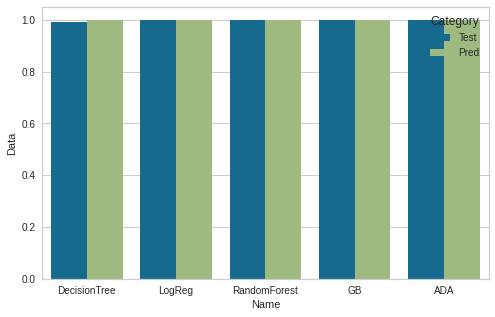

In [96]:
plt.figure(figsize=(8,5))
data1 = {'Name': names2,
         'Data': data,
         'Category': ['Test', 'Pred'] * 5}
df2 = pd.DataFrame(data1)
df2
sns.barplot(x='Name',y ='Data', data=df2, hue='Category')

In [97]:
df2

,Name,Data,Category
0,DecisionTree,0.993913,Test
1,DecisionTree,1.000000,Pred
2,LogReg,0.999368,Test
3,LogReg,1.000000,Pred
4,RandomForest,0.999982,Test
5,RandomForest,1.000000,Pred
6,GB,0.999987,Test
7,GB,1.000000,Pred
8,ADA,0.999994,Test
9,ADA,1.000000,Pred
